In [1]:
import sys
sys.path.append('../')
from src.evaluation.goal_evaluator import GoalEvaluator
from src.extraction.extractor import generate_description, generate_actors, generate_high_level_goals, generate_low_level_goals
from src.mapping.APIs_mapping import generate_mapping_apis_goals, print_api_goal_mapping
from src.self_critique.refine_response import EvalMode, generate_response_with_reflection
from src.utils import get_api_list_from_swagger
from src.examples.shot_learning import ShotPromptingMode

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Luca\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Experiments

In [ ]:
SHOTS_NUMBER = ShotPromptingMode.FEW_SHOT
PREPROCESSING = True #stemming and lemmization for the evaluation

#### Choose the project among the available ones

In [2]:
from groundtruth import GENOME, GESTAO_HOSPITAL
GROUNDTRUTH = GESTAO_HOSPITAL

### Description Generation

In [4]:
print("Description STARTING...")
description = generate_description(GROUNDTRUTH["link-readme"])
print("Description DONE...")
print(description)

Description STARTING...
Description DONE...
description='GestaoHospital is a hospital management system that aims to streamline the organization of public health services in Brazil, specifically supporting the Sistema Único de Saúde (SUS). The project seeks to create an API that enhances accessibility to healthcare information, facilitating various functionalities such as hospital registration, patient check-in/check-out processes, and inventory management of medical supplies, including blood banks. By providing these services, the system intends to improve patient care, optimize resource allocation, and help hospitals manage their operations more efficiently.'


### Actors Extraction

In [5]:
actors, actors_score, actors_critique = generate_response_with_reflection(
    "Actors",
    generate_actors,
    define_args=description,
    eval_mode=EvalMode.ACTORS,
    eval_args=description,
    shotPromptingMode=SHOTS_NUMBER,
    max_attempts=3
)

Actors STARTING... (attempt 1)
No feedback provided!
Actors DONE...
actors=[Actor(name='Patients', description='Individuals seeking medical services and care.'), Actor(name='Hospital Staff', description='Personnel involved in the hospital operations, including administrative and medical staff.'), Actor(name='Administrators', description='Individuals overseeing the management and operations of healthcare services.'), Actor(name='Healthcare Professionals', description='Doctors, nurses, and other medical staff providing patient care.'), Actor(name='Supply Chain Managers', description='Individuals responsible for managing medical supplies and inventory.')]
Evaluation for Actors STARTING...
Evaluation for Actors DONE...
Score: 8
Critique: The actors defined are mostly relevant to the hospital management system, but there seems to be an overlap between 'Hospital Staff' and 'Healthcare Professionals' as well as 'Administrators', which could potentially be merged or clarified for better distin

### High Level Goals Extraction

In [6]:
highLevelGoals, HL_score, HL_critique = generate_response_with_reflection(
    "High Level Goals",
    generate_high_level_goals,
    define_args=(description, actors),
    eval_mode=EvalMode.HIGH_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors)
)

High Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant expert in software engineering tasks You're tasked with extracting high level goals from a software description for each provided actor that is expected to interact with the software. MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end users of the software.
High Level Goals DONE...
goals=[HighLevelGoal(name='Monitor and manage patient registration and check-in/check-out processes', description='Enable patients to easily register and check in to receive medical services without delays.', actor=Actor(name='Patients', description='Individuals seeking medical services and care.')), HighLevelGoal(name='Enhance operational efficiency of hospital services', description='Allow hospital staff to streamline their operations, manage records, and coordinate services more effectively to improve ov

### Low Level Goals Extraction

In [7]:
lowLevelGoals, LL_score, LL_critique = generate_response_with_reflection(
    "Low Level Goals",
    generate_low_level_goals,
    define_args=(highLevelGoals),
    eval_mode=EvalMode.LOW_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors, highLevelGoals)
)

Low Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant expert in software engineering tasksElicit low-level goals for a specific stakeholder in a software project  The low-level goals that you create MUST be structured to match against a set of API calls. Don't be too generic, for example, avoid goals like 'make the software fast', 'develop a web interface' etc.Each low-level goal MUST be phrased as an interaction with the system that could be implemented via an API call.Avoid generic goals like 'Access genetic data'. Instead, break them down into atomic actions linked to system capabilities.
Low Level Goals DONE...
low_level_goals=[LowLevelGoal(name='Allow patients to register their personal information for hospital services', description='Enable patients to enter their name, contact, and insurance information during the registration process.', high_level_associated=HighLevelGoal(name='Monitor and manage patient regi

### APIs Extraction from Swagger

In [8]:
print("API List STARTING...")
apiList = get_api_list_from_swagger(GROUNDTRUTH["swagger"])
print("API List DONE...")
print(apiList)

API List STARTING...
API List DONE...
[API(api_name='findAllUsingGET', api_path='/v1/hospitais/', description='findAll', request_type='get'), API(api_name='insertUsingPOST', api_path='/v1/hospitais/', description='insert', request_type='post'), API(api_name='hospitalMaisProximoUsingGET', api_path='/v1/hospitais/maisProximo', description='hospitalMaisProximo', request_type='get'), API(api_name='findByIdUsingGET', api_path='/v1/hospitais/{hospital_id}', description='findById', request_type='get'), API(api_name='updateUsingPUT', api_path='/v1/hospitais/{hospital_id}', description='update', request_type='put'), API(api_name='deleteByIdUsingDELETE', api_path='/v1/hospitais/{hospital_id}', description='deleteById', request_type='delete'), API(api_name='findAllProductByUsingGET', api_path='/v1/hospitais/{hospital_id}/estoque', description='findAllProductBy', request_type='get'), API(api_name='insertUsingPOST_1', api_path='/v1/hospitais/{hospital_id}/estoque', description='insert', request_typ

### APIs Mapping to Low Level Goals

In [9]:
print("Mapping STARTING...")
mappings = generate_mapping_apis_goals(lowLevelGoals, apiList)
print("Mapping DONE")

Mapping STARTING...
hlg name:  Monitor and manage patient registration and check-in/check-out processes
Goal name:  Allow patients to register their personal information for hospital services
Goal description:  Enable patients to enter their name, contact, and insurance information during the registration process.
APIs:  insertUsingPOST, findPatientsUsingGET, updatePatientUsingPUT

hlg name:  Monitor and manage patient registration and check-in/check-out processes
Goal name:  Enable patients to check in for their appointments via the system
Goal description:  Allow patients to confirm their arrival for scheduled appointments online or through a kiosk.
APIs:  checkinPacientUsingPOST

hlg name:  Monitor and manage patient registration and check-in/check-out processes
Goal name:  Provide patients with estimated wait times for their appointments
Goal description:  Show real-time estimated waiting times for patients checking in for their appointments.
APIs:  checkinPacientUsingPOST, findPat

In [10]:
print(mappings[0].low_level_goal.high_level_associated.name)

Monitor and manage patient registration and check-in/check-out processes


### Mapping Table

In [11]:
print_api_goal_mapping(mappings)

╒══════════════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════╕
│ High-Level Goal name                                                     │ Low-Level Goal name                                                            │ Low-Level Goal description                                                                               │ Mapped APIs                                                                      │
╞══════════════════════════════════════════════════════════════════════════╪════════════════════════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════════════════════════════════════════════════╪════════════════════════════════════════

# Evaluation

### Evaluation: Extracted High Level Goals 

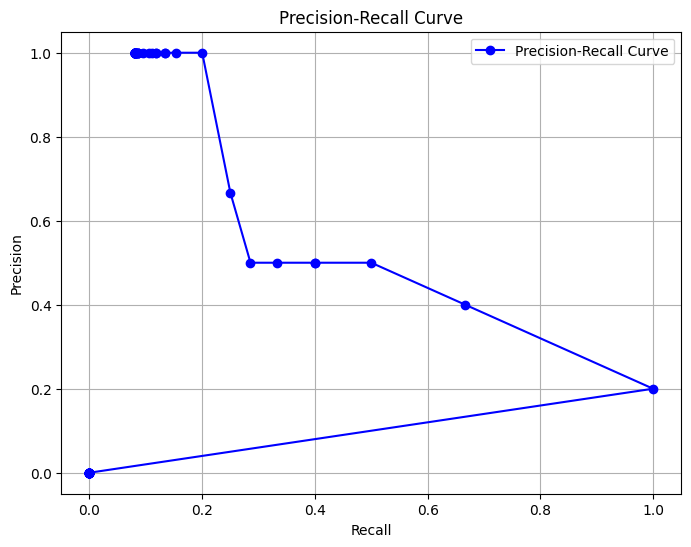

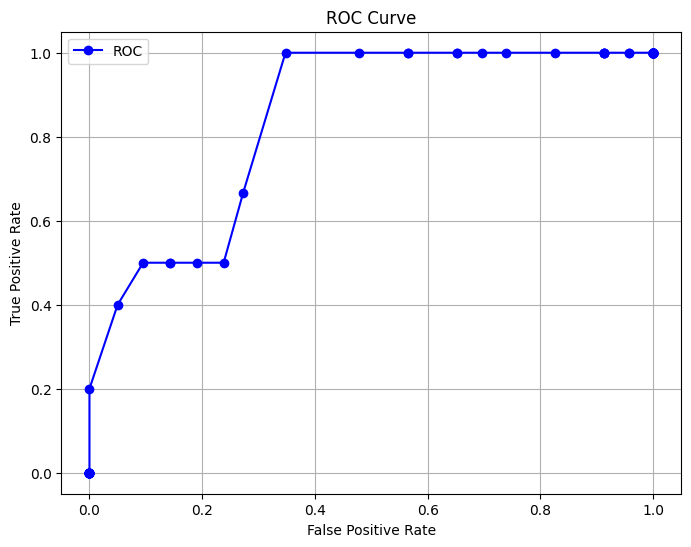

High Level ROC AUC: 0.8417439923012291
High Level Precision Recall Curve AUC: 0.44464285672060155


In [ ]:
# List of high-level goals 
generated_goals = [goal.description for goal in highLevelGoals.goals]
manual_goals = GROUNDTRUTH["highLevelGoals"]

evaluator = GoalEvaluator(preprocess = PREPROCESSING)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_goals, manual_goals)
print("High Level ROC AUC:", auc_roc)
print("High Level Precision Recall Curve AUC:", auc_prec_rec)


### Evaluation: Extracted Low Level Goals 

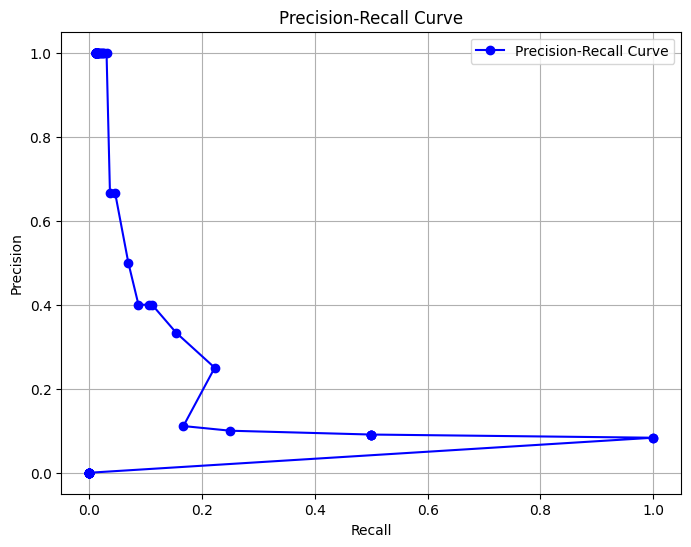

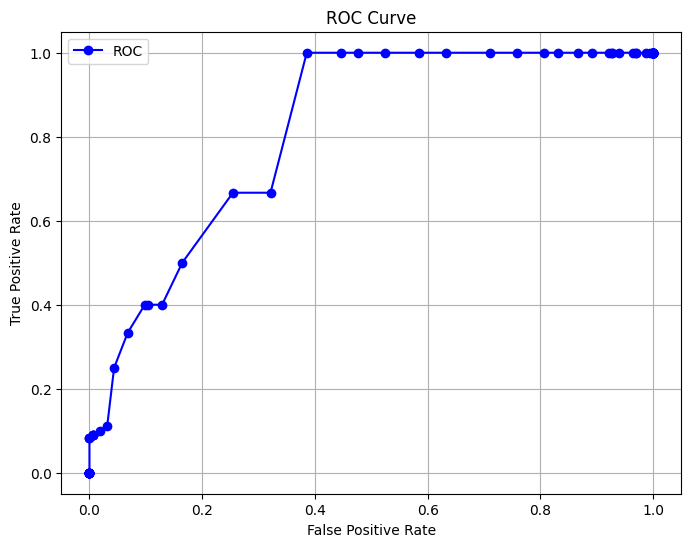

Low Level Goals ROC AUC: 0.8167735116637613
Low Level Goals Precision Recall Curve AUC: 0.13302220610783416


In [ ]:
# List of low-level goals 
generated_low_level_goals = [goal.description for goal in lowLevelGoals.low_level_goals]

manual_low_level_goals = GROUNDTRUTH["lowLevelGoals"]

evaluator_low_level = GoalEvaluator(preprocess = PREPROCESSING)

auc_roc, auc_prec_rec = evaluator_low_level.print_roc_prec_rec_curve(generated_low_level_goals, manual_low_level_goals)
print("Low Level Goals ROC AUC:", auc_roc)
print("Low Level Goals Precision Recall Curve AUC:", auc_prec_rec)

### Evaluation: Extracted Actors 

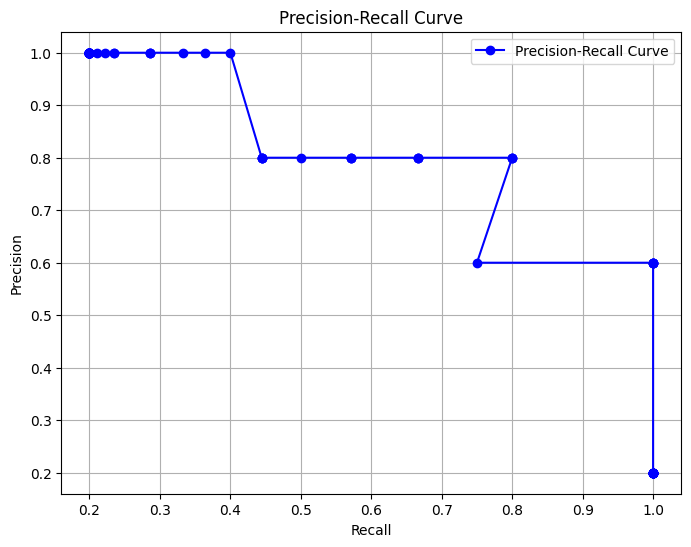

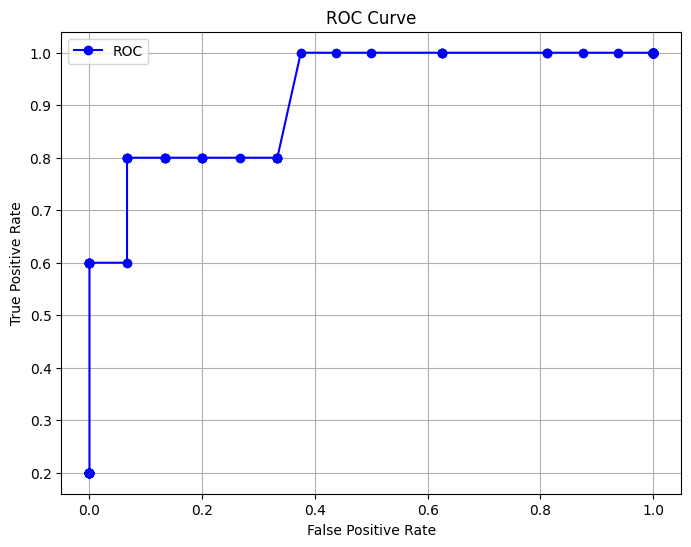

Actors ROC AUC: 0.9158333330608299
Actors Precision Recall Curve AUC: 0.6394444439850895


In [ ]:
# List of actors
generated_actors = [actor.name for actor in actors.actors]
manual_actors = GROUNDTRUTH["actors"]

evaluator = GoalEvaluator(preprocess = PREPROCESSING)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_actors, manual_actors)
print("Actors ROC AUC:", auc_roc)
print("Actors Precision Recall Curve AUC:", auc_prec_rec)